# Прогнозирование температуры поверхности звезды

##  Введение

Обсерватории «Небо на ладони» требуется придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. 

В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Цель проекта:**

 - Разработать нейронную сеть, которая предскажет абсолютную температуру на поверхности звезды.

Заказчику важны:

- точность предсказания;
- удобство использования.

**Данные:**
     
     
***Признаки:***
     

   - *Относительная светимость L/Lo — светимость звезды относительно Солнца.*
   
   - *Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.*
   
   - *Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.*
   
   - *Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.*
   
   - *Тип звезды (номер, соответствующий типу):*
     - Коричневый карлик	0
     - Красный карлик	1
     - Белый карлик	2
     - Звёзды главной последовательности	3
     - Сверхгигант	4
     - Гипергигант	5
   
   
***Целевой признак:***
     
     
   - *Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.*
   
   
  

**План выполнения проекта:**


   - Загрузить данные.
   
   
   - Провести исследовательский анализ данных.
   
   
   - Подготовить данные для обучения модели:
   

   - Построить простую модель нейронной сети — baseline.
   
   
   - Подобрать лучшие параметры сети.
  
   
   - Написать промежуточный и общий выводы.

## Загрузка данных 

In [1]:
#!pip install phik==0.10.0 -q

In [2]:
#!pip install --upgrade scikit-learn -q

In [3]:
# загружаем библиотеки
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
from math import sqrt
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import time
import warnings

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

# настраиваем отображение 
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 250)
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [4]:
# загружаем датасет 
df = pd.read_csv('/datasets/6_class.csv')

###  Вывод по первому шагу

 - Обновили и загрузили необходимые библиотеки и данные.

## Изучение и анализ данных

In [5]:
# знакомимся с данными, выводим десять случайных строк, явные и относительные дубликаты и пропуски
def data_info(df):
    d = {'data' : df}
    for a, i in d.items():
        # дубликаты
        print('Датасет:',a,'абсолютное количество явных дубликатов:',i.duplicated().sum())    
        print('Датасет:',a,'относительное количество явных дубликатов:',i.duplicated().sum()/df.shape[0])
        print()
        # пропуски
        print('Датасет:',a,'абсолютное количество пропусков:')
        print(i.isna().sum().sort_values()) 
        print()
        print('Датасет:',a,'относительное количество пропусков:')    
        print((i.isna().sum()/df.shape[0]).sort_values())
        # строки и инфо
        display(i.sample(10))
        print()
        i.info()
# выводим         
data_info(df)   

Датасет: data абсолютное количество явных дубликатов: 0
Датасет: data относительное количество явных дубликатов: 0.0

Датасет: data абсолютное количество пропусков:
Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

Датасет: data относительное количество пропусков:
Unnamed: 0                0.0
Temperature (K)           0.0
Luminosity(L/Lo)          0.0
Radius(R/Ro)              0.0
Absolute magnitude(Mv)    0.0
Star type                 0.0
Star color                0.0
dtype: float64


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
229,229,21738,748890.000000,92.0000,-7.346,4,Blue
219,219,8250,9.250000,1.9300,-0.980,3,yellow-white
101,101,40000,813000.000000,14.0000,-6.230,4,Blue
6,6,2637,0.000730,0.1270,17.220,0,Red
170,170,3570,320000.000000,1480.0000,-7.580,5,Red
239,239,37882,294903.000000,1783.0000,-7.800,5,Blue
187,187,3484,0.000551,0.0998,16.670,0,Red
79,79,3158,0.001350,0.1610,13.980,1,Red
15,15,3340,0.003800,0.2400,13.070,1,Red
27,27,7700,0.000110,0.0128,14.470,2,Yellowish White



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [6]:
# проверяем количество уникальных значений в столбце с названиями звезд
df['Unnamed: 0'].nunique()

240

 
 - Пропусков и дубликатов нет.
 
 - В столбце с названиями звезд ('Unnamed: 0') значения совпадают с индексом. Удалим столбец перед обучением за ненадобностью, а в качестве названия звезды будем использовать индекс. 
 
 - Типы данных соответствуют назначению. Числовые типы заменим на более экономные.
 
 - Поправим названия столбцов.  
 
 - Проверим данные на наличие аномалий.

In [7]:
# смотрим уникальные значения в столбцах с категориальными признаками

# выбираем столбцы
df_columns_category  = df.columns[-2:]

def values_unique(data):
    for column in df_columns_category:
        values1 = data[column].unique()
        values2 = data[column].nunique()
        values3 = data[column].value_counts(normalize=True)
        print('Уникальные значения столбца:', column)
        print(values1)
        print('Количество уникальных значений столбца:', column)
        print(values2)
        print('Относительное распределение уникальных значений столбца:', column)
        print(values3)
        print()
    
values_unique(df)    

Уникальные значения столбца: Star type
[0 1 2 3 4 5]
Количество уникальных значений столбца: Star type
6
Относительное распределение уникальных значений столбца: Star type
0    0.166667
1    0.166667
2    0.166667
3    0.166667
4    0.166667
5    0.166667
Name: Star type, dtype: float64

Уникальные значения столбца: Star color
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']
Количество уникальных значений столбца: Star color
19
Относительное распределение уникальных значений столбца: Star color
Red                   0.466667
Blue                  0.229167
Blue-white            0.108333
Blue White            0.041667
yellow-white          0.033333
White                 0.029167
white                 0.012500
Blue white            0.012500
Yellowish White       0.012500
yellowish             0.008333
Orange

 - В столбце с типом звезды ('Star type') аномалии не наблюдаются. При этом, к каждому типу отнесено одинаковое количество звезд.

 - В столбце с цветом звезды ('Star color') много аномалий. Поправим значения. 
 
 - Некоторые цвета представлены в единичных количествах. Объединим их с близкой категорией. 

In [8]:
# избавляемся от аномалий в столбце Star color
def df_str_replace(data):
    data=data.str.strip() # удаляем лишние пробелы в строках
    data=data.str.lower() # приводим символы к нижнему регистру
    data=data.replace(['-', ' '],['_','_'], regex=True) # меняем пробелы и тире на нижнее подчеркивание 
    data=data.replace(
    ['blue_white', 'white_yellow', 
     'yellowish',  'yellowish_white', 
     'whitish', 
     'orange_red', 'pale_yellow_orange'  
],
    ['white_blue', 'yellow_white', 
     'yellow',     'yellow_white', 
     'white', 
     'orange', 'orange' 
], 
        regex=True) # переименовываем неявные дубликаты 
    
    return data

df['Star color'] = df_str_replace(df['Star color'])    

In [9]:
# проверяем
df['Star color'].unique()

array(['red', 'white_blue', 'white', 'yellow_white', 'orange', 'blue',
       'yellow'], dtype=object)

In [10]:
# смотрим распределение цветов по долям и количеству
print(df['Star color'].value_counts(normalize=True))
print()
df['Star color'].value_counts()

red             0.466667
blue            0.233333
white_blue      0.170833
yellow_white    0.050000
white           0.050000
orange          0.016667
yellow          0.012500
Name: Star color, dtype: float64



red             112
blue             56
white_blue       41
yellow_white     12
white            12
orange            4
yellow            3
Name: Star color, dtype: int64

In [11]:
# смотрим распределение числовых значений
df.describe()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


 - Количественные признаки имеют разную размерность. Потребуется масштабирование. 
 
 - Значения светимости ('Luminosity(L/Lo)') лежат в очень широком диапазоне значений. 

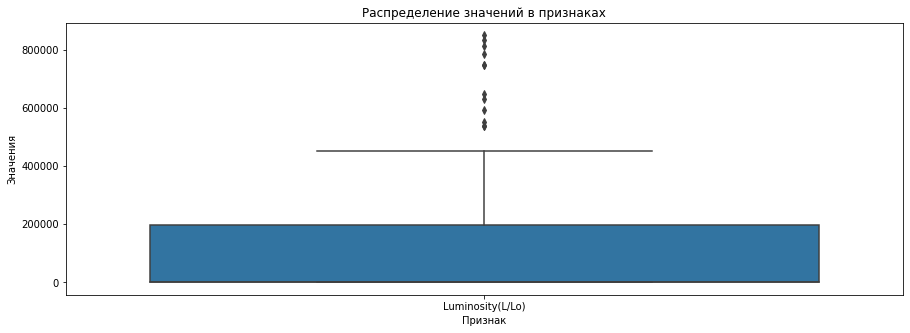

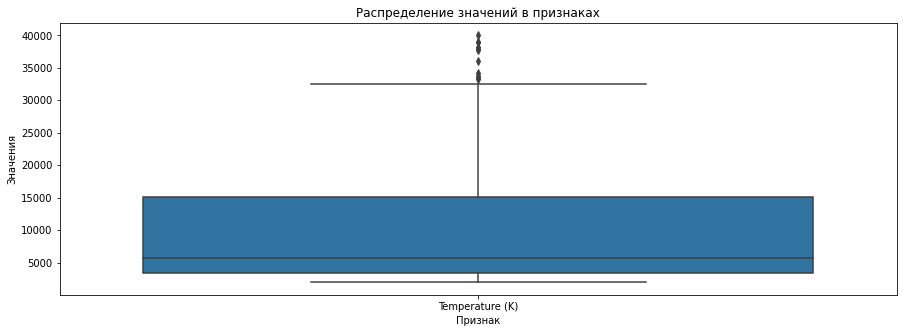

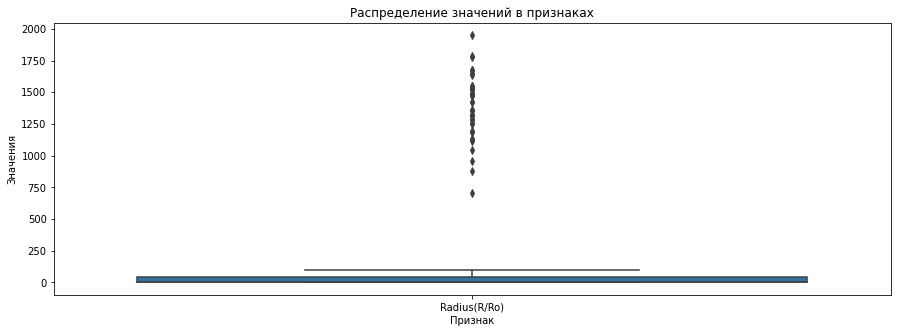

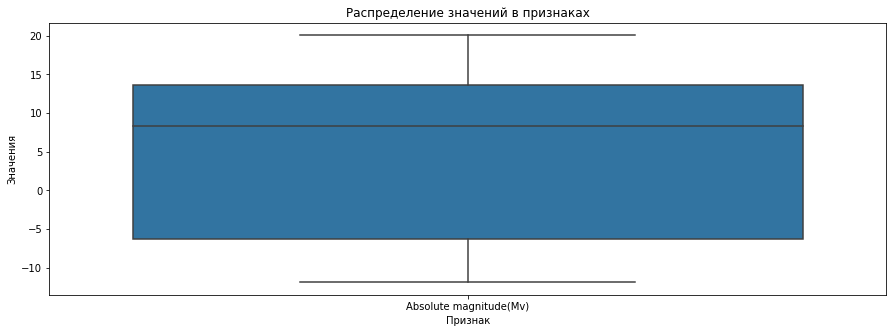

In [12]:
# смотрим разброс данных на диаграмме разброса
def boxplotly(df):
    
    plt.figure(figsize=(15, 5))    
    sns.boxplot(data=df)
    plt.xlabel('Признак')
    plt.ylabel('Значения')
    plt.title('Распределение значений в признаках')
    plt.show()   

# смотрим разброс в данных
column = ['Luminosity(L/Lo)']   
boxplotly(df[column])
column = ['Temperature (K)']
boxplotly(df[column])
column = ['Radius(R/Ro)'] 
boxplotly(df[column])
column = ['Absolute magnitude(Mv)'] 
boxplotly(df[column])

 - В данных с температурой ('Temperature (K)'), радиусом ('Radius(R/Ro)') и светимостью ('Luminosity(L/Lo)') присутствуют выбросы. Удалять не имеет смысла: очень мало данных. Избавимся от них при масштабировании признаков.
  
 - Посмотрим распределение количественных признаков на гистограммах.

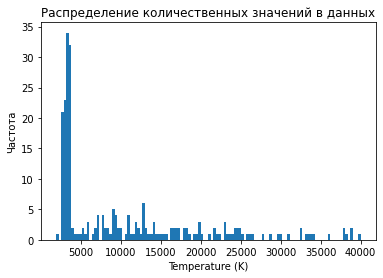

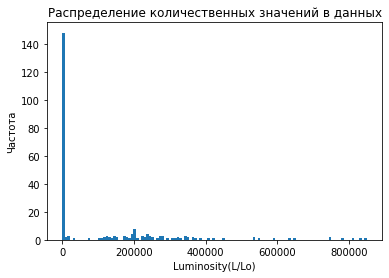

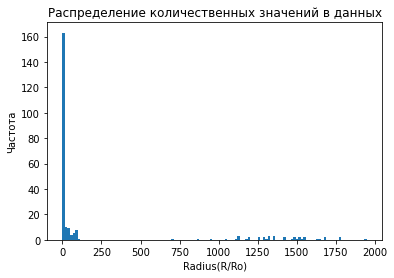

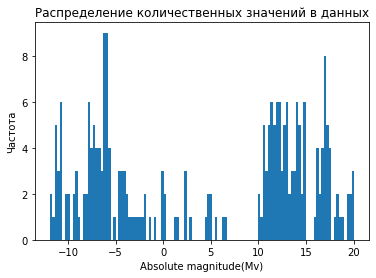

In [13]:
# строим гистограммы для числовых данных
columns_plot = ['Temperature (K)', 
                'Luminosity(L/Lo)', 
                'Radius(R/Ro)',
                'Absolute magnitude(Mv)']

def plot_hist(data, bins, size):
    for column in columns_plot:
        
        data[column].plot(bins=bins, kind='hist')                         
    
        plt.grid=True
        plt.legend=False 
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.title('Распределение количественных значений в данных')
        plt.show()       
        
plot_hist(df, 120, (12,6))

 - Данных мало, поэтому картина получается размазанной. Если не учитывать выбросы, количественные данные в основном распределены равномерно. 

 - Посмотрим на графиках категориальные признаки и избавимся от аномалий.

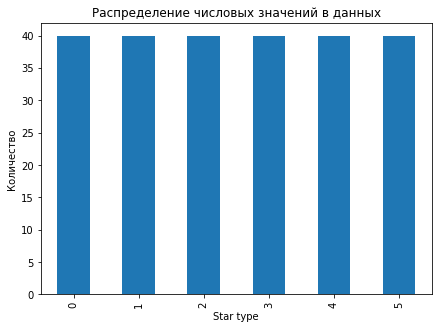

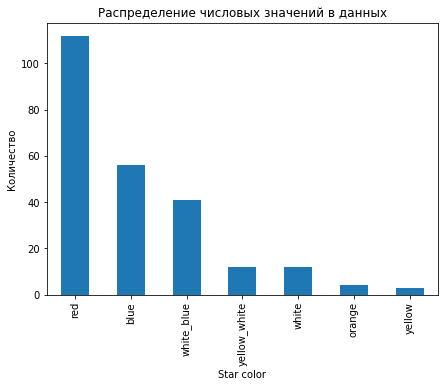

In [14]:
# строим столбчатые диаграммы категориальных данных 
def plot_bar(data, size):
    for column in df_columns_category:
        
        plt.figure(figsize=size)
        data[column].value_counts().plot(kind='bar')                         
    
        plt.grid=True        
        plt.legend=False 
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.title('Распределение числовых значений в данных')
        plt.show()       
        
plot_bar(df,(7,5))

 - Звезды по типам распределены абсолютно равномерно. Больше всего в датасете красных звезд. На втором месте - звезды голубого цвета.
 
 - Посмотрим сочетание цвета и других характеристик.

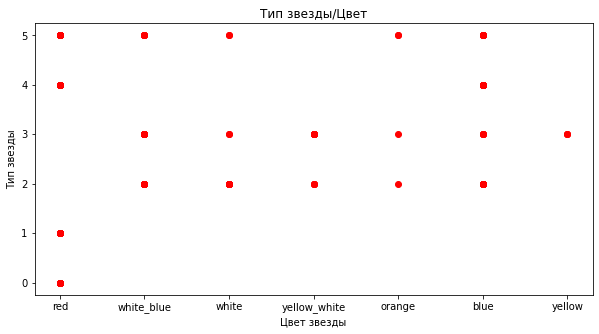

In [15]:
# создаем функцию
def plot_plot(x, y, color, title, ylabel):
        
    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'o', color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Цвет звезды')
 
    plt.show()  
    
# строим график соответствия типа звезды и ее цвета        
plot_plot(df['Star color'], df['Star type'], "r", 'Тип звезды/Цвет', 'Тип звезды') 

 - Самые ненаполненные типы - 0 и 1. К ним принадлежат только красные звезды.  
 
 - Наибольшее разнообразие наблюдается у 3 типа - он охватывают звезды 6 разных цветов.   
 
 - В то же время, звезды одного и того же цвета могут принадлежать к разным типам. 

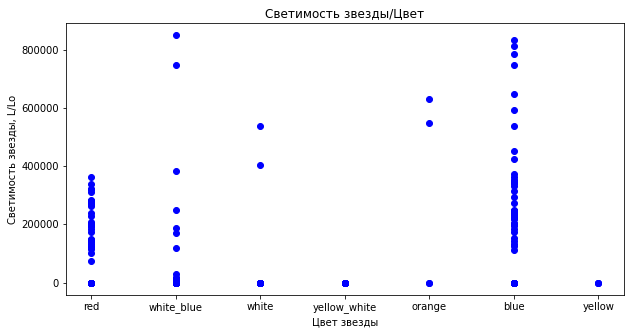

In [16]:
# строим график соответствия цвета звезды и ее светимости
plot_plot(df['Star color'], df['Luminosity(L/Lo)'], "b", 'Светимость звезды/Цвет', 'Светимость звезды, L/Lo') 

 - Наибольший разброс светимости - у голубых звезд, причем большая часть этих звезд занимает узкий диапазон. Похожая картина наблюдается у красных звезд, но они не выходят из узкого диапазона светимости. 
 
 - Наиболее яркие звезды - в области голубого спектра.   
 

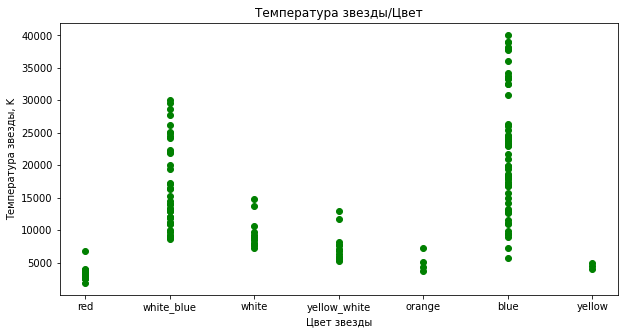

In [17]:
# строим график соответствия цвета звезды и ее температуры
plot_plot(df['Star color'], df['Temperature (K)'], "g", 'Температура звезды/Цвет', 'Температура звезды, K') 

- Среди голубых звезд наблюдается самый широкий разброс по температуре. Чуть меньше - у звезд бело-голубого цвета. 

- Наиболее холодные звезды - красного цвета. Наиболее горячие - голубого. 

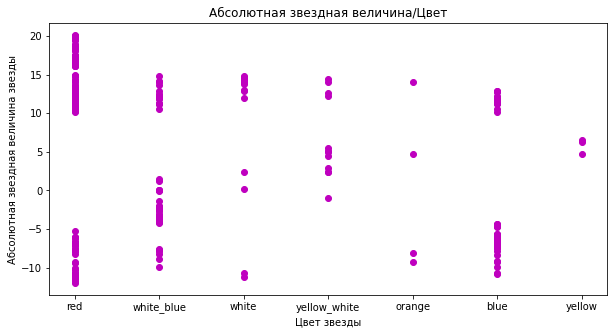

In [18]:
# строим график соответствия цвета звезды и ее блеска
plot_plot(df['Star color'], 
          df['Absolute magnitude(Mv)'], 
          "m", 'Абсолютная звездная величина/Цвет', 
          'Абсолютная звездная величина звезды')

 - Блеск (Абсолютная звездная величина) звезд распределяется внутри одного и того же цветового спектра на два и более дискретных диапазона. 

 - Посмотрим на корреляцию признаков. 

In [19]:
# выбираем столбцы
columns = df.columns[1:]

# выбираем интервал
interval_cols = ['Temperature (K)', 
                 'Luminosity(L/Lo)', 
                 'Radius(R/Ro)',
                 'Absolute magnitude(Mv)', 
                 'Star type']

# задаем матрицу корреляции
corr_matrix = df[columns].phik_matrix(interval_cols=interval_cols)

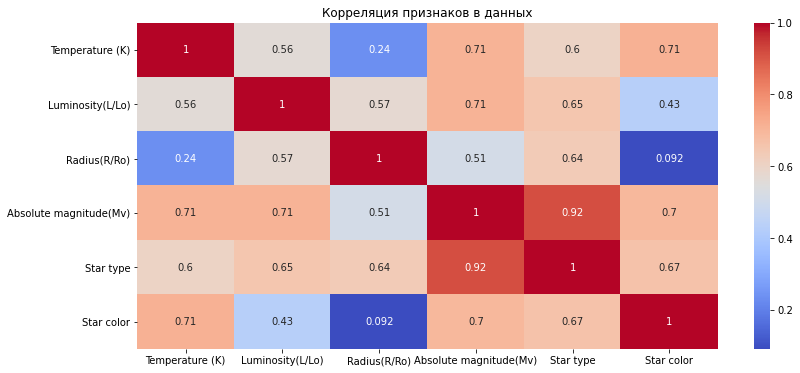

In [20]:
# визуализируем матрицу корреляции через тепловую карту
plt.figure(figsize=(13, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm')
plt.title('Корреляция признаков в данных')
plt.show() 

 - Наблюдается сильная корреляция типа звезды и абсолютной звездной величины. Придется удалить один из этих признаков, чтобы избежать нестабильной работы модели. 
 
 - Наибольшую корреляцию с температурой звезды демонстрируют ее абсолютная величина и цвет.  
 
 - Самая низкая корреляция наблюдается между радиусом и цветом звезды. 

###  Вывод по второму шагу

 - Исследовали количественные и категориальные данные.  Проверили на корреляцию и выбросы:
 
   - Наиболее яркие и горячие звезды испускают свет в области голубого спектра;
   
   - Количественные данные в основном распределены равномерно, но имеют выбросы.
  
   - Наибольшую корреляцию с температурой звезды демонстрируют ее абсолютная величина и цвет.
   


 - Избавились от аномалий в столбце с цветом звезд (Star color) и сократили количество классов в категории цвета.
 
 
 - Наметили признаки для удаления и новый - для синтезирования.
 

## Подготовка данных к обучению

 - Удалим неинформативный столбец (Unnamed: 0) и исправим названия остальных столбцов.


 - Создадим новый признак - характеристику (класс звезды) по температуре (холодная/горячая). Источник информации: (https://ru.wikipedia.org/wiki/Спектральная_классификация_звёзд). 
 
 
 - Удалим столбец с типом звезды (Star type), чтобы избежать мультиколлинеарности.


 - Разделим данные на обучающую и тестовую выборки.


 - Проведем масштабирование количественных признаков и кодирование категориальных. 

In [21]:
# удаляем ненужный столбец
df.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
# переименовываем столбцы 
df.columns = ['temperature', 'luminosity', 'radius_relative',
       'absolute_magnitude', 'star_type', 'star_color']

In [23]:
# создаем новую категорию - характеристику по температуре (холодная/горячая).

#создаем функцию категоризации
def class_temperature(temperature):
        
    if temperature >=30000:
        return 'extremely_hot'

    elif  10000 <= temperature < 30000:
        return 'very_hot'

    elif   7400 <= temperature < 10000:  
        return 'hot'
       
    elif   6000 <= temperature < 7400:     
        return 'almost_hot'

    elif   5000 <= temperature < 6000:             
        return 'warm'

    elif   3800 <= temperature < 5000:            
        return 'cold'
      
    return 'very_cold' 
  
# создаем новый столбец t_class 
df['t_class'] = df['temperature'].apply(class_temperature)

In [24]:
# проверяем значения в новом столбце
df['t_class'].value_counts()

very_cold        109
very_hot          75
hot               21
extremely_hot     15
almost_hot         7
cold               7
warm               6
Name: t_class, dtype: int64

In [25]:
# удаляем столбец с типом звезды
df.drop('star_type', axis=1, inplace=True)

# проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         240 non-null    int64  
 1   luminosity          240 non-null    float64
 2   radius_relative     240 non-null    float64
 3   absolute_magnitude  240 non-null    float64
 4   star_color          240 non-null    object 
 5   t_class             240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


In [26]:
# формируем выборки: обучающую(75%) тестовую(25%)
features_train, features_test, target_train, target_test = train_test_split(
    df.drop(columns=['temperature']),
    df.temperature,
    test_size=0.25,
    random_state=1234)

# проверяем
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(180, 5)
(180,)
(60, 5)
(60,)


In [27]:
# задаем категориальные признаки для кодировки
ohe_features = ['star_color', 't_class']

# задаем численные признаки для масштабирования
scaler_features = ['luminosity',
                   'radius_relative',
                   'absolute_magnitude']

In [28]:
# активируем кодировщик категориальных признаков
encoder_ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

# кодируем категориальные признаки
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

# удаляем лишние столбцы 
features_train = features_train.drop(ohe_features, axis=1)

In [29]:
# кодируем категориальные признаки в тестовом наборе, кодировщиком, обученным на тренировочной
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

# удаляем лишние столбцы 
features_test = features_test.drop(ohe_features, axis=1)

# проверяем размер итоговых выборок
print(features_train.shape) 
print(features_test.shape)

(180, 15)
(60, 15)


In [30]:
# масштабируем численные признаки 
scaler = StandardScaler()
scaler.fit(features_train[scaler_features])
features_train[scaler_features] = scaler.transform(features_train[scaler_features])
features_test[scaler_features] = scaler.transform(features_test[scaler_features])

# проверяем размер итоговых выборок
print(features_train.shape) 
print(features_test.shape)

(180, 15)
(60, 15)


### Вывод по третьему шагу

 - Удалили один неинформативный столбец(Unnamed: 0), и второй (Star type) -  чтобы избавиться от мультиколлинеарности.
 
 
 - Исправили названия столбцов.


 - Создали новый признак (t_class) - температурную характеристику. 
 

 - Разделили данные на обучающую и тестовую выборки.


 - Провели масштабирование количественных и кодирование категориальных признаков. 

## Построение базовой нейронной сети

### Пробное предсказание

 - Получим предсказание алгоритмом Случайного леса из sklearn и оценим важность признаков.  

In [31]:
%%time
# создаем модель и получаем предсказание Случайного леса
model_RFR = RandomForestRegressor(random_state=1234)
model_RFR.fit(features_train, target_train)
predict_RFR = model_RFR.predict(features_test)

rmse_RFR = round(mean_squared_error(target_test, predict_RFR, squared=False),2)
print('RMSE Случайного леса на тестовой выборке:', rmse_RFR)

RMSE Случайного леса на тестовой выборке: 3120.99
CPU times: user 167 ms, sys: 0 ns, total: 167 ms
Wall time: 167 ms


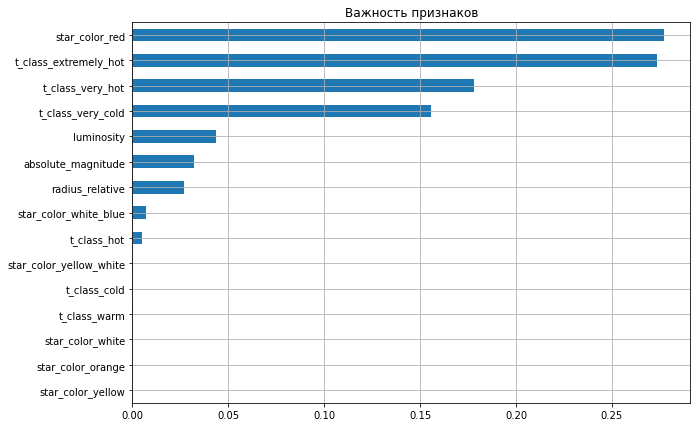

In [32]:
# оценим важность признаков
plt.title('Важность признаков')
pd.Series(model_RFR.feature_importances_, index=features_train.columns)\
            .sort_values(ascending=True).plot.barh(figsize=(10,7), grid=True);

 - Модель Случайного леса показала неплохой результат прямо "из коробки", предсказуемо оценив наиболее распространенные признаки как самые важные .  
 
 
 - Посмотрим, какие результаты предсказаний покажет нейросеть.

### Создание базовой модели нейросети

In [33]:
# создаем тензоры для обучения нейросети
X_train = torch.FloatTensor(features_train.values)
X_test = torch.FloatTensor(features_test.values)
y_train = torch.FloatTensor(target_train.values)
y_test = torch.FloatTensor(target_test.values)

In [34]:
# задаем гиперпараметры нейросети
n_in_neurons = X_train.shape[1]
n_out_neurons = 1 
n_hidden_neurons_1 = 800
n_hidden_neurons_2 = 400
n_hidden_neurons_3 = 200

# задаем скорость обучения
learning_rate = 1e-3

#  задаем функцию потерь 
loss = nn.MSELoss()  

# задаем количество эпох, размер и количество батчей
num_epochs = 1000 
batch_size = 100
num_batches = ceil(len(X_train)/batch_size)

# задаем воспроизводимость результатов
torch.manual_seed(1234)

- Сначала создадим модель через объявление класса. 

In [35]:
# создаем модель с двумя скрытыми слоями  
class NNet(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                                   n_hidden_neurons_2, n_out_neurons):
        super(NNet, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
# задаем прямой проход       
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.act1(x)
        
        x = self.fc2(x)       
        x = self.act2(x)
        
        x = self.fc3(x)       
    
        return x

# инициализируем сеть 
net = NNet(n_in_neurons, n_hidden_neurons_1, 
                       n_hidden_neurons_2, n_out_neurons) 

# выводим архитектуру 
print('Архитектура нейросети:')
print(net)

# проверяем работу
res_nnet = net.forward(X_train)
print('Среднее значение выхода:',res_nnet.mean()) 

Архитектура нейросети:
NNet(
  (fc1): Linear(in_features=15, out_features=800, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=800, out_features=400, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=400, out_features=1, bias=True)
)
Среднее значение выхода: tensor(0.0206, grad_fn=<MeanBackward0>)


- Модель работает. Упростим код - используем контейнер Sequential.

In [36]:
# создаем и инициализируем сеть
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
)

# выводим архитектуру
print('Архитектура нейросети:')
print(net) 

# проверяем работу
res_nnet_sq = net.forward(X_train) 
print('Среднее значение выхода:',res_nnet_sq.mean()) 

Архитектура нейросети:
Sequential(
  (0): Linear(in_features=15, out_features=800, bias=True)
  (1): ReLU()
  (2): Linear(in_features=800, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=1, bias=True)
)
Среднее значение выхода: tensor(0.0216, grad_fn=<MeanBackward0>)


- Сравним несколько комбинаций параметров (количество скрытых слоёв, количество нейронов на них, функции активации на скрытых и выходном слоях).

In [37]:
# создаем модель с произвольных количеством слоев
n_neurons = [n_in_neurons, 800, 400, 200, 
                100, 50, 10, n_out_neurons]
net_layers = []

for i in range(1, len(n_neurons) - 1):
    # добавим полносвязный слой
    net_layers.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
    
    # добавим функцию активации для чётных и нечетных слоёв
    if (i+1) % 2 == 0:
        net_layers.append(nn.Tanh())    
    else:
        net_layers.append(nn.ReLU()) 

# добавляем выходной слой        
net_layers.append(nn.Linear(n_neurons[-2], n_neurons[-1])) 

# создаем и инициализируем сеть
net = nn.Sequential(*net_layers)

# выводим архитектуру
print('Архитектура нейросети:')
print(net) 

# проверяем работу
res_nnet_sq_r = net.forward(X_train) 
print('Среднее значение выхода:',res_nnet_sq_r.mean()) 

Архитектура нейросети:
Sequential(
  (0): Linear(in_features=15, out_features=800, bias=True)
  (1): Tanh()
  (2): Linear(in_features=800, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=200, bias=True)
  (5): Tanh()
  (6): Linear(in_features=200, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=50, bias=True)
  (9): Tanh()
  (10): Linear(in_features=50, out_features=10, bias=True)
  (11): ReLU()
  (12): Linear(in_features=10, out_features=1, bias=True)
)
Среднее значение выхода: tensor(-0.1451, grad_fn=<MeanBackward0>)


In [38]:
# создаем модель с произвольных количеством слоев
n_neurons = [n_in_neurons, 600, 200, 100, 
                50, 5, n_out_neurons]
net_layers = []

for i in range(1, len(n_neurons) - 1):
    # добавим полносвязный слой
    net_layers.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
    net_layers.append(nn.ReLU()) 

# добавляем выходной слой        
net_layers.append(nn.Linear(n_neurons[-2], n_neurons[-1])) 

# создаем и инициализируем сеть
net = nn.Sequential(*net_layers)

# выводим архитектуру
print('Архитектура нейросети:')
print(net) 

# проверяем работу
res_nnet_sq_r = net.forward(X_train) 
print('Среднее значение выхода:',res_nnet_sq_r.mean()) 

Архитектура нейросети:
Sequential(
  (0): Linear(in_features=15, out_features=600, bias=True)
  (1): ReLU()
  (2): Linear(in_features=600, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=5, bias=True)
  (9): ReLU()
  (10): Linear(in_features=5, out_features=1, bias=True)
)
Среднее значение выхода: tensor(0.3777, grad_fn=<MeanBackward0>)


 - Модели с разной архитектурой вполне работоспособны.
 
 
 - Так как признаков и объектов мало, чтобы избежать переобучения, в качестве базовой модели оставим модель с двумя скрытыми слоями - 800 и 400 нейронов, соответственно. 
 

### Обучение базовой  модели 
 
 - Оптимизируем работу модели, добавим обратный проход (обратное распространение ошибки) и проверим точность предсказаний.  

In [39]:
%%time
# создаем и инициализируем сеть с двумя скрытыми слоями
net_1 = nn.Sequential(
     nn.Linear(n_in_neurons, n_hidden_neurons_1),
     nn.ReLU(),
     nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
     nn.ReLU(),
     nn.Linear(n_hidden_neurons_2, n_out_neurons)
)
# выводим архитектуру нейросети
print('Архитектура нейросети:')
print(net_1)

# создаем Adam оптимизатор
optimizer = torch.optim.Adam(net_1.parameters(), lr=learning_rate)  

print('Показатели нейронной сети на тестовой выборке:')

# создаем список полученных значений RMSE 
res_1 = np.array([])

# обучаем на заданном количестве эпох (1000)
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # прямой проход
    preds = net_1.forward(X_train).flatten()     
    loss_value = loss(preds, y_train)
    
    # обратный проход
    loss_value.backward()        
    optimizer.step()
   
    # выводим результат каждую сотую и в последнюю эпоху 
    if epoch % 100 == 0 or epoch == num_epochs - 1:                
        net_1.eval()
        test_preds = net_1.forward(X_test)
        rmse_Nnet_1 = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
       
        res_1 = np.append(res_1, rmse_Nnet_1)  
        
        print(f'Эпоха {round(epoch+i/num_epochs)},\
                RMSE: {round(rmse_Nnet_1,2)}, Количество эпох: {num_epochs}')

best_rmse_Nnet_1 =  round(res_1.min(),2)
best_epoch_1 = res_1.argmin()*100

print()
print('Лучшее значение RMSE:', best_rmse_Nnet_1 , ', Эпоха:', best_epoch_1) 

Архитектура нейросети:
Sequential(
  (0): Linear(in_features=15, out_features=800, bias=True)
  (1): ReLU()
  (2): Linear(in_features=800, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=1, bias=True)
)
Показатели нейронной сети на тестовой выборке:
Эпоха 0,                RMSE: 15177.61, Количество эпох: 1000
Эпоха 100,                RMSE: 13649.77, Количество эпох: 1000
Эпоха 200,                RMSE: 7581.63, Количество эпох: 1000
Эпоха 300,                RMSE: 6325.51, Количество эпох: 1000
Эпоха 400,                RMSE: 5360.41, Количество эпох: 1000
Эпоха 500,                RMSE: 4513.63, Количество эпох: 1000
Эпоха 600,                RMSE: 3966.68, Количество эпох: 1000
Эпоха 700,                RMSE: 3741.67, Количество эпох: 1000
Эпоха 800,                RMSE: 3670.73, Количество эпох: 1000
Эпоха 900,                RMSE: 3647.12, Количество эпох: 1000
Эпоха 999,                RMSE: 3634.3, Количество эпох: 1000

Лучшее значение RM

- Визуализируем обучение модели.

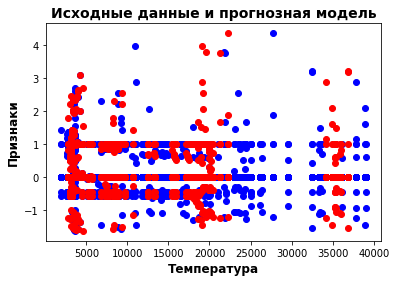

In [40]:
# создаем график признаки/ предсказанная температура 
plt.plot(y_train, X_train,'go', color="b")
plt.plot(preds.detach().numpy(), X_train, 'o', color="r")
plt.title('Исходные данные и прогнозная модель', fontsize=14, weight='bold')
plt.xlabel("Температура", fontsize=12, weight='bold')
plt.ylabel("Признаки", fontsize=12, weight='bold')
plt.show()

- Видно, что модель неплохо обучается. Но точность не идеальная. Особенно в диапазоне 25000-30000K.

 - Посмотрим на другом графике насколько точен прогноз модели на тестовой выборке по сравнению с реальными значениями.

In [41]:
# создаем датафреймы с предсказаниями и фактическими значениями
test_predict = pd.DataFrame(test_preds.detach().numpy(), 
                            columns=['temperature'])
test_target = pd.DataFrame(y_test.detach().numpy(), 
                           columns=['temperature'])    

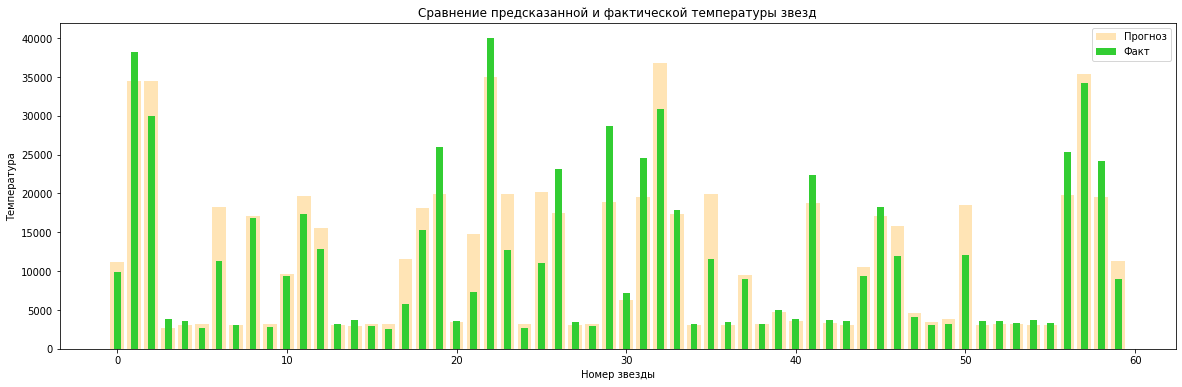

In [42]:
# строим график
fig, ax = plt.subplots(figsize=[20,6])
plt.title('Сравнение предсказанной и фактической температуры звезд')
plt.bar(x=test_predict.index, 
        height=test_predict['temperature'], color='moccasin', 
            label='Прогноз')
plt.bar(x=test_target.index, 
        height=test_target['temperature'], color='limegreen', 
            label='Факт', width= 0.4)
plt.xlabel('Номер звезды')
plt.ylabel('Температура')
ax.legend()
plt.show()  

- На графике видно, что на низких температурах модель предсказывает довольно точно. 

 - Добавим обучение на батчах.

In [43]:
%%time
# создаем и инициализируем сеть с двумя скрытыми слоями
net_2 = nn.Sequential(
     nn.Linear(n_in_neurons, n_hidden_neurons_1),
     nn.ReLU(),
     nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
     nn.ReLU(),
     nn.Linear(n_hidden_neurons_2, n_out_neurons)
)

# создаем Adam оптимизатор
optimizer = torch.optim.Adam(net_2.parameters(), lr=learning_rate)

print('Показатели нейронной сети на тестовой выборке:')

# создаем список полученных значений RMSE 
res_2 = np.array([])

# обучаем на заданном количестве эпох (1000)
for epoch in range(num_epochs):
    
    # добавляем обучение на батчах 
       
    # переставляем объекты случайным образом
    order = np.random.permutation(len(X_train)) 
   
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()
        
        # получаем индексы текущего батча
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        # прямой проход
        preds = net_2.forward(X_train).flatten()     
        loss_value = loss(preds, y_train)
        
        # обратный проход
        loss_value.backward()        
        optimizer.step()
    
    # выводим результат каждую сотую и в последнюю эпохи 
    if epoch % 100 == 0 or epoch == num_epochs - 1:                
        net_2.eval()
        
        test_preds = net_2.forward(X_test)
        rmse_Nnet_2 = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
        
        res_2 = np.append(res_2, rmse_Nnet_2)
        
        print(f'Эпоха {round(epoch+i/num_epochs)},\
                RMSE: {round(rmse_Nnet_2,2)}, Количество эпох: {num_epochs}, Размер батча: {batch_size}')  
        
best_rmse_Nnet_2 =  round(res_2.min(),2)
best_epoch_2 = res_2.argmin()*100

print()
print('Лучшее значение RMSE:', best_rmse_Nnet_2 , ', Эпоха:', best_epoch_2, ', Батчей:', num_batches)        

Показатели нейронной сети на тестовой выборке:
Эпоха 0,                RMSE: 15177.16, Количество эпох: 1000, Размер батча: 100
Эпоха 100,                RMSE: 7544.86, Количество эпох: 1000, Размер батча: 100
Эпоха 200,                RMSE: 5336.19, Количество эпох: 1000, Размер батча: 100
Эпоха 300,                RMSE: 3955.85, Количество эпох: 1000, Размер батча: 100
Эпоха 400,                RMSE: 3670.35, Количество эпох: 1000, Размер батча: 100
Эпоха 500,                RMSE: 3634.12, Количество эпох: 1000, Размер батча: 100
Эпоха 600,                RMSE: 3618.88, Количество эпох: 1000, Размер батча: 100
Эпоха 700,                RMSE: 3614.99, Количество эпох: 1000, Размер батча: 100
Эпоха 800,                RMSE: 3623.7, Количество эпох: 1000, Размер батча: 100
Эпоха 900,                RMSE: 3640.59, Количество эпох: 1000, Размер батча: 100
Эпоха 999,                RMSE: 3666.84, Количество эпох: 1000, Размер батча: 100

Лучшее значение RMSE: 3614.99 , Эпоха: 700 , Батчей:

 - Модель на батчах сначала обучается хорошо, но затем переобучается: после 700-й эпохи значение метрики ухудшается. 

### Вывод по четвертому шагу

 - Создали архитектуру и обучили модель нейронной сети с двумя скрытыми слоями. 
 
 
 - Добавили обучение на батчах и получили предсказания:
 
   - Лучшее значение RMSE без батчей - **3634.3** на 1000 эпохах;
   
   - Лучшее значение RMSE на батчах - **3614.99** на 700-й эпохе. Дальше наблюдается переобучение.  
 
 
 - Попробуем улучшить предсказания базовой модели.

## Улучшение нейронной сети

 - Добавим обучение с перебором параметров. 
 
 
 - Сначала изменим размеры батчей. 

In [44]:
# задаем размер батчей
batch_values = [25, 50, 80, 100]

In [45]:
%%time
# создаем список полученных значений RMSE 
res_3 = np.array([])    
    
# запускаем обучение
for batch_size in batch_values:
    # создаем и инициализируем сеть с двумя скрытыми слоями
    net_3 = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_2, n_out_neurons)
)
    
    # создаем Adam оптимизатор
    optimizer = torch.optim.Adam(net_3.parameters(), lr=learning_rate)
    
    # задаем количество батчей 
    num_batches = ceil(len(X_train)/batch_size)
       
    # обучаем на заданном количестве эпох (1000)
    for epoch in range(num_epochs):
        # добавляем обучение на батчах 
        # переставляем объекты случайным образом
        order = np.random.permutation(len(X_train)) 
   
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()
        
            # получаем индексы текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            # прямой проход
            preds = net_3.forward(X_train).flatten()     
            loss_value = loss(preds, y_train)
        
            # обратный проход
            loss_value.backward()        
            optimizer.step()
               
    # получаем предсказание на тестовой выборке              
    net_3.eval()
    test_preds = net_3.forward(X_test)
    rmse_Nnet_3 = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
  
    res_3 = np.append(res_3, rmse_Nnet_3)
    
    print(f'Размер батча: {batch_size}, RMSE: {round(rmse_Nnet_3,2)}, Количество эпох: {num_epochs}') 
    
best_rmse_Nnet_3 = round(res_3.min(),2)
best_batch_size = batch_values[res_3.argmin()]
print()
print('Лучшее значение RMSE:', best_rmse_Nnet_3 , ', Размер батча:', best_batch_size, ', Батчей:', num_batches)     

Размер батча: 25, RMSE: 5637.78, Количество эпох: 1000
Размер батча: 50, RMSE: 4578.74, Количество эпох: 1000
Размер батча: 80, RMSE: 3807.31, Количество эпох: 1000
Размер батча: 100, RMSE: 3654.41, Количество эпох: 1000

Лучшее значение RMSE: 3654.41 , Размер батча: 100 , Батчей: 2
CPU times: user 5min 54s, sys: 6.8 s, total: 6min 1s
Wall time: 6min 43s


 - При увеличении размера батча и, соответственно, уменьшении количества батчей, метрика улучшается: модель меньше переобучается.   
 
 
 - С ростом количества батчей, растет и время обучения. 

 - Теперь переберём разное количество эпох. Результат визуализируем.

In [46]:
%%time
# создаем и инициализируем сеть с двумя скрытыми слоями
net_4 = nn.Sequential(
     nn.Linear(n_in_neurons, n_hidden_neurons_1),
     nn.ReLU(),
     nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
     nn.ReLU(),
     nn.Linear(n_hidden_neurons_2, n_out_neurons)
)

# создаем Adam оптимизатор
optimizer = torch.optim.Adam(net_4.parameters(), lr=learning_rate)  

# создаем список полученных значений RMSE 
res_4 = np.array([])

# обучаем на количестве эпох 3000
for epoch in range(1, 3001):
    optimizer.zero_grad()
    
    # прямой проход
    preds = net_4.forward(X_train).flatten()     
    loss_value = loss(preds, y_train)
    
    # обратный проход
    loss_value.backward()        
    optimizer.step()
   
    # выводим результат каждую десятую эпоху 
    if epoch % 10 == 0 :                
        net_4.eval()
        test_preds = net_4.forward(X_test)
        rmse_Nnet_4 = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
        
        res_4 = np.append(res_4, rmse_Nnet_4)

# выбираем лучшие показатели        
best_rmse_Nnet_4 =  round(res_4.min(),2)
best_epoch_4 = (res_4.argmin()*10)+10       

CPU times: user 57.4 s, sys: 1.35 s, total: 58.8 s
Wall time: 59.1 s


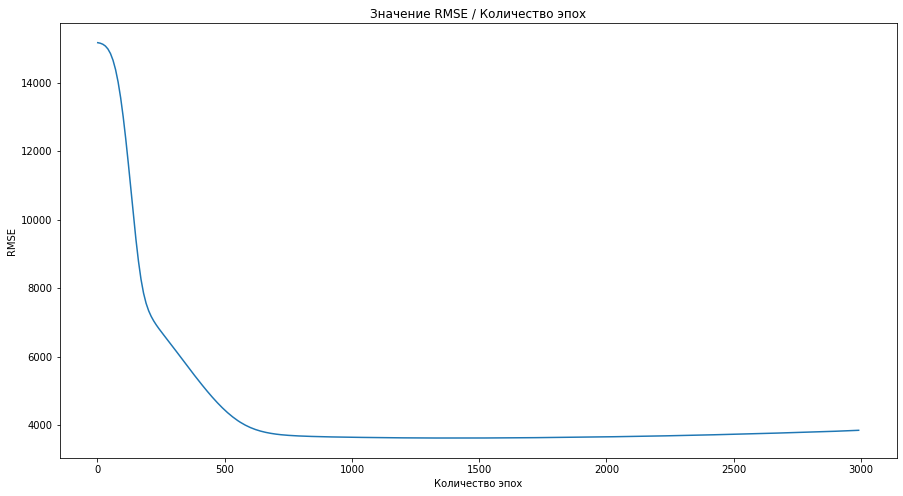

Лучшее значение RMSE: 3617.84 , Эпоха: 1410


In [47]:
# задаем вектор эпох
epochs = np.arange(1, 3001, 10)        

# строим график 
plt.figure(figsize=[15,8])
plt.title('Значение RMSE / Количество эпох')
sns.lineplot(x=epochs, y=res_4)
plt.xlabel('Количество эпох')
plt.ylabel('RMSE')
plt.show()

print('Лучшее значение RMSE:', best_rmse_Nnet_4, ', Эпоха:', best_epoch_4) 

 - После 1410-й эпохи метрика падает (ухудшается). Видимо, модель переобучается. Оставим оптимальное количество эпох - 1500.

- Попробуем применить Dropout. Добавим в модель новые слои и зададим долю выключаемых нейронов.

In [48]:
# задаем количество эпох и долю выключаемых нейронов
num_epochs_5 = 1500
prop_dropout = [0.25, 0.3, 0.5, 0.8]

In [49]:
%%time
# создаем список полученных значений RMSE 
res_5 = np.array([])

# запускаем обучение
for p in prop_dropout:
    # создаем и инициализируем сеть с двумя скрытыми слоями
    net_5 = nn.Sequential(
         nn.Linear(n_in_neurons, n_hidden_neurons_1),
         nn.ReLU(),
         nn.Dropout(p=p),
         nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
         nn.ReLU(),
         nn.Dropout(p=p),
         nn.Linear(n_hidden_neurons_2, n_out_neurons)
)

    # создаем Adam оптимизатор     
    optimizer = torch.optim.Adam(net_5.parameters(), lr=learning_rate)  

   
    # обучаем на количестве эпох 1500
    for epoch in range(num_epochs_5):
        optimizer.zero_grad()
    
        # прямой проход
        preds = net_5.forward(X_train).flatten()     
        loss_value = loss(preds, y_train)
    
        # обратный проход
        loss_value.backward()        
        optimizer.step()
   
    # получаем предсказание на тестовой выборке            
    net_5.eval()
    test_preds = net_5.forward(X_test)
    rmse_Nnet_5 = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
       
    res_5 = np.append(res_5, rmse_Nnet_5)  
    
    print(f'Доля dropout: {p}, RMSE: {round(rmse_Nnet_5,2)}, Количество эпох: {num_epochs_5}')

best_rmse_Nnet_5 =  round(res_5.min(),2)
best_dropout = prop_dropout[res_5.argmin()]
print()
print('Лучшее значение RMSE:', best_rmse_Nnet_5, ', Доля dropout:', best_dropout)  

Доля dropout: 0.25, RMSE: 3625.45, Количество эпох: 1500
Доля dropout: 0.3, RMSE: 3602.23, Количество эпох: 1500
Доля dropout: 0.5, RMSE: 3601.79, Количество эпох: 1500
Доля dropout: 0.8, RMSE: 3608.0, Количество эпох: 1500

Лучшее значение RMSE: 3601.79 , Доля dropout: 0.5
CPU times: user 1min 57s, sys: 2.46 s, total: 1min 59s
Wall time: 2min 1s


 - Модель показывает лучший результат при 50% выключенных нейронов.

- Запустим модель с подобранными параметрами.

In [50]:
%%time
# создаем и инициализируем сеть с двумя скрытыми слоями
net_6 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Dropout(p=best_dropout),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Dropout(p=best_dropout),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
)

# создаем Adam оптимизатор     
optimizer = torch.optim.Adam(net_6.parameters(), lr=learning_rate)  
    
# создаем список полученных значений RMSE 
res_6 = np.array([])

# обучаем на количестве эпох 1500
for epoch in range(num_epochs_5):
    optimizer.zero_grad()
    
    # прямой проход
    preds = net_6.forward(X_train).flatten()     
    loss_value = loss(preds, y_train)
    
    # обратный проход
    loss_value.backward()        
    optimizer.step()
   
    # выводим результат каждую сотую и в последнюю эпохи 
    if epoch % 100 == 0 or epoch == num_epochs_5 - 1:                
        net_6.eval()
        
        test_preds = net_6.forward(X_test)
        rmse_Nnet_6 = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
        
        res_6 = np.append(res_6, rmse_Nnet_6)
        
        print(f'Эпоха {round(epoch+i/num_epochs_5)},\
            RMSE: {round(rmse_Nnet_6,2)}, Количество эпох: {num_epochs_5}, Доля dropout: {best_dropout}')  
        
best_rmse_Nnet_6 = round(res_6.min(),2)
best_epoch_6 = res_6.argmin()*100

print()
print('Лучшее значение RMSE:', best_rmse_Nnet_6 , ', Эпоха:', best_epoch_6)

Эпоха 0,            RMSE: 15177.5, Количество эпох: 1500, Доля dropout: 0.5
Эпоха 100,            RMSE: 13609.17, Количество эпох: 1500, Доля dropout: 0.5
Эпоха 200,            RMSE: 7631.81, Количество эпох: 1500, Доля dropout: 0.5
Эпоха 300,            RMSE: 6379.11, Количество эпох: 1500, Доля dropout: 0.5
Эпоха 400,            RMSE: 5419.6, Количество эпох: 1500, Доля dropout: 0.5
Эпоха 500,            RMSE: 4568.43, Количество эпох: 1500, Доля dropout: 0.5
Эпоха 600,            RMSE: 4005.84, Количество эпох: 1500, Доля dropout: 0.5
Эпоха 700,            RMSE: 3764.58, Количество эпох: 1500, Доля dropout: 0.5
Эпоха 800,            RMSE: 3686.05, Количество эпох: 1500, Доля dropout: 0.5
Эпоха 900,            RMSE: 3658.51, Количество эпох: 1500, Доля dropout: 0.5
Эпоха 1000,            RMSE: 3643.6, Количество эпох: 1500, Доля dropout: 0.5
Эпоха 1100,            RMSE: 3632.82, Количество эпох: 1500, Доля dropout: 0.5
Эпоха 1200,            RMSE: 3624.85, Количество эпох: 1500, Доля

 - Сравним на графике прогноз модели и реальные значения.

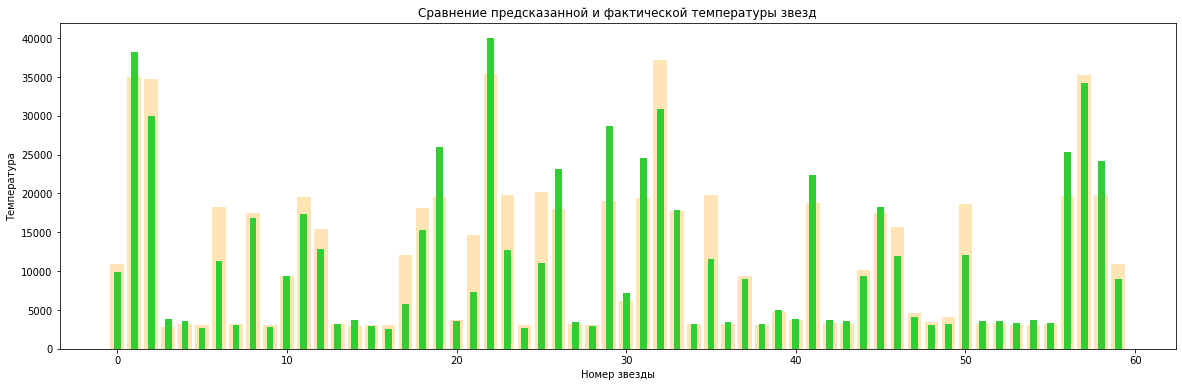

In [51]:
# создаем датафреймы с предсказаниями и фактическими значениями
test_predict = pd.DataFrame(test_preds.detach().numpy(), 
                            columns=['temperature'])
test_target = pd.DataFrame(y_test.detach().numpy(), 
                           columns=['temperature'])    

# строим график
fig, ax = plt.subplots(figsize=[20,6])
plt.title('Сравнение предсказанной и фактической температуры звезд')
plt.bar(x=test_predict.index, 
        height=test_predict['temperature'], color='moccasin', 
            label='Прогноз')
plt.bar(x=test_target.index, 
        height=test_target['temperature'], color='limegreen', 
            label='Факт', width= 0.4)
plt.xlabel('Номер звезды')
plt.ylabel('Температура')

plt.show()  

- Составим сводную таблицу результатов работы моделей с разными параметрами.

In [52]:
# создаем таблицу с результатами работы моделей
data={'model':  ['RFregressor',
                 'Nnet_1',
                 'Nnet_2',
                 'Nnet_3',
                 'Nnet_4',
                 'Nnet_5',
                 'Nnet_6'
                ],

    'hidden_layers': [0,
                      2,
                      2,
                      2,
                      2,
                      2,
                      2 
                     ],
   
    'epochs': [0,
               best_epoch_1,
               best_epoch_2,
               num_epochs,
               best_epoch_4,
               num_epochs_5,
               best_epoch_6
              ],
    
    'batches':[0,
               0,
               num_batches,
               num_batches,
               0,
               0,
               0
              ], 
      
    'batch_size':[0,
                  0,
                  batch_size,
                  best_batch_size,
                  0,
                  0,
                  0
                  ],  
                  
    'dropout':[0,
               0,
               0,
               0,
               0,
               best_dropout,
               best_dropout
               ],
    
    'RMSE': [rmse_RFR,
             best_rmse_Nnet_1,
             best_rmse_Nnet_2,
             best_rmse_Nnet_3,
             best_rmse_Nnet_4,
             best_rmse_Nnet_5,
             best_rmse_Nnet_6],
   }


# выводим результаты
scores_model = pd.DataFrame(data).sort_values(by='RMSE')
scores_model

,model,hidden_layers,epochs,batches,batch_size,dropout,RMSE
0,RFregressor,0,0,0,0,0.0,3120.99
5,Nnet_5,2,1500,0,0,0.5,3601.79
2,Nnet_2,2,700,2,100,0.0,3614.99
6,Nnet_6,2,1400,0,0,0.5,3617.45
4,Nnet_4,2,1410,0,0,0.0,3617.84
1,Nnet_1,2,1000,0,0,0.0,3634.30
3,Nnet_3,2,1000,2,100,0.0,3654.41


### Вывод по пятому шагу

 - Провели обучение базовой модели с перебором различных параметров: размера батчей, размера эпох, параметров dropout. 
 
 
 - Визуализировали результаты обучения моделей.
 
 
 - Составили итоговую таблицу сравнения результатов моделей с разными параметрами.  

## Общий вывод

- **В процессе работы над проектом мы:**

    - Загрузили и изучили данные.
   
    - Провели исследовательский анализ данных: исследовали количественные и категориальные данные; проверили на корреляцию и выбросы; избавились от аномалий в столбце с цветом звезд и сократили количество классов в категории цвета; наметили признаки для удаления и синтезирования.
   
    - Подготовили данные для обучения модели: удалили неинформативный столбец, удалили один из столбцов с сильной взаимной корреляцией; исправили названия столбцов; создали новый синтетический категориальный признак (температурный класс); разделили данные на обучающую и тестовую выборки; провели масштабирование количественных и кодирование категориальных признаков.  
   
    - Построили простую модель нейронной сети — baseline: создали архитектуру и обучили модель нейронной сети с двумя скрытыми слоями, 800 и 400 нейронов, соответственно; добавили обучение на батчах и получили предсказания на тестовой выборке;  
   
    - Подобрали лучшие параметры нейросети: провели обучение базовой модели с перебором различных параметров и визуализировали результаты, составили итоговую сравнительную таблицу.
   
    - Написали промежуточный и общий выводы.
   
   
 - **Резюме:**   
 
    - Среди нейронных сетей **лучше других** с задачей справилась **модель с двумя скрытыми слоями** (по 800 и 400 нейронов), на **1500 эпохах** обучения и **50% выключенных нейронов**. **Время работы** модели составляет **около 30 секунд**. Модель показала значение метрики **RMSE 3601.79**, что можно считать хорошим результатом. **Модель можно рекомендовать** к использованию**.